<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Data

In [2]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/559 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/176523 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/557 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/996k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37667 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/173k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3553 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/548 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/178 [00:00<?, ? examples/s]

In [19]:
data = df_300
data = data.set_index("timestamp")
#data.head()

In [21]:
origin = "2023-06-01"
start = "2023-07-01" # origin + prediction_lenght
end = "2023-07-01"

train_data = data["2022-12-20":origin]
valid_data = data[origin:end]
test_data = data[end:]

#### Scaling

In [22]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [23]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 12
epochs = 10

# Models

## Forecasting one-step-ahead

In [24]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [26]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']
ts = test['avg_invocations_rate'][:-1]

In [27]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    ts.to_numpy(),
    targets=ts[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0146 - mae: 0.0987 - val_loss: 0.0039 - val_mae: 0.0382
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0016 - mae: 0.0320 - val_loss: 0.0031 - val_mae: 0.0332
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0013 - mae: 0.0286 - val_loss: 0.0027 - val_mae: 0.0303
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0011 - mae: 0.0265 - val_loss: 0.0024 - val_mae: 0.0287
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 9.5318e-04 - mae: 0.0249 - val_loss: 0.0022 - val_mae: 0.0267
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 8.7562e-04 - mae: 0.0238 - val_loss: 0.0021 - val_mae: 0.0256
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 8.2290e-04 - mae: 0.0230 - val_loss: 0.0021 - val_mae: 0.0252
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 7.8136e-04 - mae: 0.0225 - val_loss: 0.0020 - val_mae: 0.0249
Epoch 9/10
925/925 ━━━━━━━━━

23655.828088521957

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


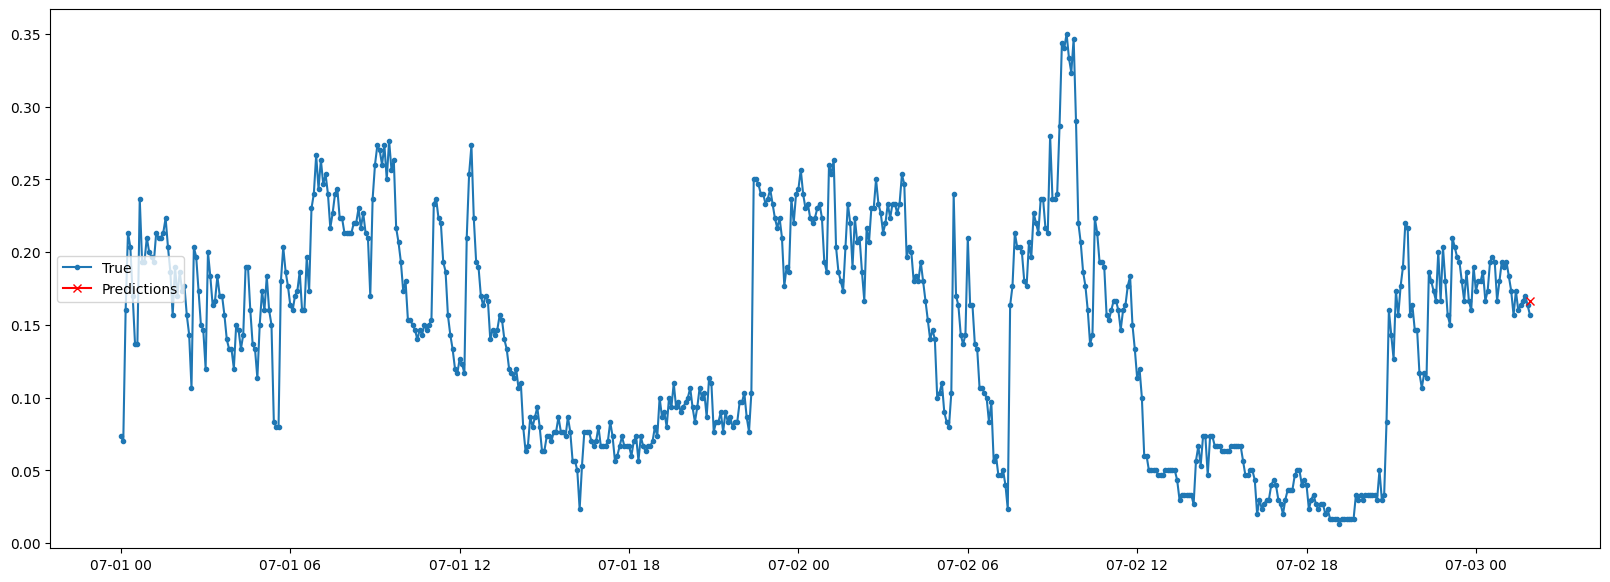

In [31]:
Y_pred = model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [12]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0137 - mae: 0.1411 - val_loss: 0.0010 - val_mae: 0.0342
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0058 - mae: 0.0861 - val_loss: 0.0029 - val_mae: 0.0685
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0057 - mae: 0.0909 - val_loss: 0.0015 - val_mae: 0.0421
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036 - mae: 0.0677 - val_loss: 0.0050 - val_mae: 0.0923
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0040 - mae: 0.0731 - val_loss: 0.0016 - val_mae: 0.0438
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0031 - mae: 0.0612 - val_loss: 7.3756e-04 - val_mae: 0.0322
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0032 - mae: 0.0658 - val_loss: 7.9285e-04 - val_mae: 0.0308
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0024 - mae: 0.0544 - val_loss: 0.0016 - val_mae: 0.0451
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0026 - mae: 

30808.111652731895

#### Deep RNN

In [14]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [15]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - loss: 0.0028 - mae: 0.0578 - val_loss: 0.0015 - val_mae: 0.0452
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0027 - mae: 0.0579 - val_loss: 0.0016 - val_mae: 0.0456
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0031 - mae: 0.0658 - val_loss: 0.0013 - val_mae: 0.0424
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0030 - mae: 0.0624 - val_loss: 9.7672e-04 - val_mae: 0.0382
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0025 - mae: 0.0603 - val_loss: 0.0023 - val_mae: 0.0559
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0026 - mae: 0.0560 - val_loss: 0.0022 - val_mae: 0.0551
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0026 - mae: 0.0555 - val_loss: 0.0027 - val_mae: 0.0620
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0034 - mae: 0.0644 - val_loss: 0.0019 - val_mae: 0.0501
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0023 - mae: 0.0

35440.56788086891

### Multivariate Series

In [16]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [17]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/10


ValueError: Exception encountered when calling SimpleRNNCell.call().

[1mDimensions must be equal, but are 6 and 12 for '{{node sequential_3_1/simple_rnn_4_1/simple_rnn_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_3_1/simple_rnn_4_1/strided_slice_4, sequential_3_1/simple_rnn_4_1/simple_rnn_cell_1/Cast/ReadVariableOp)' with input shapes: [?,6], [12,12].[0m

Arguments received by SimpleRNNCell.call():
  • sequence=tf.Tensor(shape=(None, 6), dtype=float32)
  • states=('tf.Tensor(shape=(None, 12), dtype=float32)',)
  • training=True

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

In [ ]:
X = vl.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [ ]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [ ]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X) # shape [1, 14]
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [ ]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Perchè sembra migliorare? dovrebbe peggiorare (?)

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=valid.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - valid["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [ ]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [ ]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
fit_and_evaluate(gru, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [ ]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

In [ ]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train, seq2seq_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [ ]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
longer_train = to_seq2seq_dataset(train, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght*2)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid)

In [ ]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['avg_invocations_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [ ]:
trimmed_valid = vl.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid, order=(3, 1, 4))
arima = arima.fit()

In [ ]:
# Forecasting
forecast = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(vl.index, vl, label='Observed')
plt.plot(pd.date_range(trimmed_valid.index[-1], periods=prediction_lenght, freq='D'), forecast, label='Forecast', color='red')
plt.axvline(trimmed_valid.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()